In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import gc

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm

import math
import numpy as np
import pickle

pd.options.display.max_columns = 500

def clip_y(y):
    return [min(y, 20) for y in y]

clip_y(np.array([1, 2, 3, 4, 56, 77, 20]))

[1, 2, 3, 4, 20, 20, 20]

In [ ]:
df = pd.read_pickle("data/processed/sales_monthly_wide_reduced.pickle",)

In [ ]:
print(list(df.columns))

In [ ]:
df.head(2)

# Decision Tree

## Initial observation with a non time series setup (not usable for november prediciton)

First we start with a standard model, which is not adjusted to thew time series nature of the problem,
i.e. we do a vertical split. This results easily in an rmse of < 0.8, which would be an outstanding result in the real competition.

In [ ]:
df = df.set_index(["shop_id", "item_id"])
y = df["sum_item_cnt_month_33"]

for col in df.columns:
    if "33" in col:
        print(f"Removing column {col}")
        del df[col]
    
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

X_train

In [ ]:
model_tree = DecisionTreeRegressor(
    max_depth=10,
    min_samples_leaf=100,
)

model_tree.fit(X_train, y_train)

In [ ]:
y_pred_test = model_tree.predict(X_test)
y_pred_train = model_tree.predict(X_train)

print(f"""
Error on test: {mean_squared_error(y_true=clip_y(y_test), y_pred=clip_y(y_pred_test), squared=False)}
Error on train: {mean_squared_error(y_true=clip_y(y_train), y_pred=clip_y(y_pred_train), squared=False)}
""")

In [ ]:
del df, y, X_train, X_test, y_train, y_test, y_pred_test, y_pred_train, model_tree

gc.collect()

## predicting via time series structure

In [ ]:
df = pd.read_pickle(f"data/processed/sales_monthly_subseries_18.pickle")
df

In [ ]:
df.info()

In [ ]:
# shuffle data
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
import math

y = df["sum_item_cnt_month_18"]

for col in df:
    if "18" in col:
        print(f"deleting column {col}")
        del df[col]
        
split_index = math.floor(df.shape[0] * 0.7)

split_index

In [ ]:
%time

model_tree_series = DecisionTreeRegressor(
    max_depth=5,
    criterion="mse",  # one of "mse", "friedman_mse", "mae", "poisson"
    min_samples_leaf=250
)

model_tree_series.fit(
    df.iloc[:split_index,:],
    y[:split_index]
)

In [ ]:
print(f"""
Error on train: {
    mean_squared_error(
        y_true=clip_y(y[:split_index]),
        y_pred=clip_y(model_tree_series.predict(df.iloc[:split_index,:])),
        squared=False
    )
}
Error on test: {
    mean_squared_error(
        y_true=clip_y(y[split_index:]),
        y_pred=clip_y(model_tree_series.predict(df.iloc[split_index:,:])),
        squared=False
    )
}
""")

In [ ]:
with open('data/models/model_tree_series.pickle', 'wb') as file:
    pickle.dump(model_tree_series, file)   

In [ ]:
with open('data/models/model_tree_series.pickle', 'rb') as model:
    model_tree_series = pickle.load(model)

In [ ]:
"""Create dataset for predicting on"""
k = 18

df = pd.read_pickle(f"data/processed/sales_monthly_wide_reduced.pickle")

cols = ["shop_id", "item_id", "item_category_id"]
col_index_list = [str(x) for x in range(34 - k, 34)]
cols += [col for col in df.columns if col.split("_")[-1] in col_index_list]
df = df[cols]

df

In [ ]:
preds = clip_y(model_tree_series.predict(df))

df["pred"] = preds

plt.hist(preds, bins=100)

df

In [ ]:
submission = df[["shop_id", "item_id", "pred"]]

submission

In [ ]:
test = pd.read_csv("data/source/test.csv")

test

In [ ]:
merged = submission.join(test.set_index(["shop_id", "item_id"]), how="right", on=["shop_id", "item_id"])

merged

In [ ]:
submission = merged[["ID", "pred"]].reset_index(drop=True)

submission.columns = ["ID", "item_cnt_month"]

submission = submission.fillna(0)

submission

In [ ]:
submission.sort_values(by="item_cnt_month")

In [ ]:
submission.to_csv("data/submission_decision_tree2.csv", index=False)

# Random forest

In [2]:
%%time

"""Fitting"""

from sklearn.ensemble import RandomForestRegressor

print("Loading dataset for training")
df = pd.read_pickle(f"data/processed/sales_monthly_subseries_18.pickle")
print("shuffling...")
df = df.sample(frac=1).reset_index(drop=True)

y = df["sum_item_cnt_month_18"]

for col in df:
    if "18" in col:
        print(f"deleting column {col}")
        del df[col]
        
split_index = math.floor(df.shape[0] * 0.7)

print("Fitting Random Forest...")
model_rf_series = RandomForestRegressor(
    n_estimators=10,
    max_depth=8,
    criterion="mse",  # one of "mse", "friedman_mse", "mae", "poisson"
    min_samples_leaf=250
)

model_rf_series.fit(
    df.iloc[:split_index,:],
    y[:split_index]
)

with open('data/models/model_rf_series.pickle', 'wb') as file:
    pickle.dump(model_rf_series, file)

print("Scoring...")
print(f"""
Error on train: {
    mean_squared_error(
        y_true=clip_y(y[:split_index]),
        y_pred=clip_y(model_rf_series.predict(df.iloc[:split_index,:])),
        squared=False
    )
}
Error on test: {
    mean_squared_error(
        y_true=clip_y(y[split_index:]),
        y_pred=clip_y(model_rf_series.predict(df.iloc[split_index:,:])),
        squared=False
    )
}
""")

Loading dataset for training
shuffling...
deleting column sum_item_cnt_month_18
deleting column max_item_cnt_month_18
deleting column max_date_18
deleting column count_date_18
Fitting Random Forest...
Scoring...

Error on train: 0.7798035638013321
Error on test: 0.779794157518133

CPU times: user 8min 37s, sys: 8.01 s, total: 8min 45s
Wall time: 8min 56s


[('sum_item_cnt_month_17', 0.5563742417885769),
 ('count_date_17', 0.3718165800473524),
 ('max_item_cnt_month_13', 0.03486362590699952),
 ('max_date_17', 0.008201328956607183),
 ('sum_item_cnt_month_15', 0.005082491931546494),
 ('sum_item_cnt_month_16', 0.00456773940552291),
 ('item_category_id', 0.003101735292266243),
 ('sum_item_cnt_month_14', 0.0023771031654109286),
 ('max_item_cnt_month_17', 0.0018381339640708364),
 ('max_item_cnt_month_14', 0.0018022324648708711)]

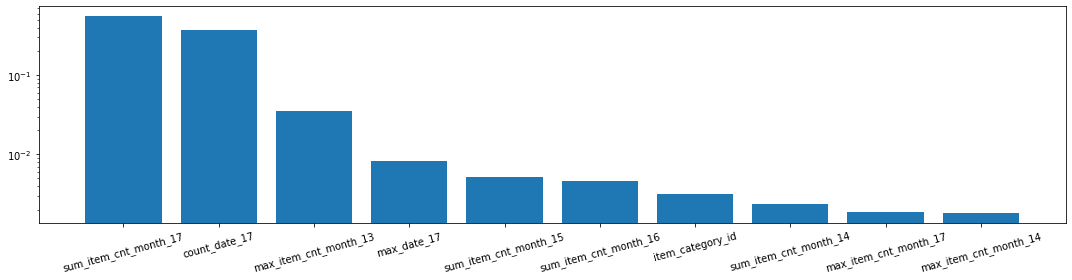

In [3]:
"""feature importance"""

feature_imp = list(zip(df.columns, model_rf_series.feature_importances_))
feature_imp.sort(key = lambda x: x[1], reverse=True)

items=10

display(feature_imp[:items])

fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.bar(
    [f[0] for f in feature_imp][:items],
    [f[1] for f in feature_imp][:items]
)
ax.tick_params(axis='x', labelrotation=15)
ax.set_yscale("log")

plt.tight_layout()
plt.show()

In [ ]:
print("""
current best:
model_rf_series = RandomForestRegressor(
    n_estimators=20,
    max_depth=10,
    criterion="mse",  # one of "mse", "friedman_mse", "mae", "poisson"
    min_samples_leaf=250
)
Error on train: 0.7723917541685946
Error on test: 0.7779497955509741

CPU times: user 26min 52s, sys: 7.84 s, total: 27min
Wall time: 27min 48s
""")

In [7]:
%%time

"""predictions"""
    
with open('data/models/model_rf_series.pickle', 'rb') as model:
    model_rf_series = pickle.load(model)
    
"""Create dataset for predicting on"""
k = 18

df = pd.read_pickle(f"data/processed/sales_monthly_wide_reduced.pickle")

cols = ["shop_id", "item_id", "item_category_id"]
col_index_list = [str(x) for x in range(34 - k, 34)]
cols += [col for col in df.columns if col.split("_")[-1] in col_index_list]
df = df[cols]

preds = clip_y(model_rf_series.predict(df))
df["pred"] = preds

submission = df[["shop_id", "item_id", "pred"]]
test = pd.read_csv("data/source/test.csv")

merged = submission.join(test.set_index(["shop_id", "item_id"]), how="right", on=["shop_id", "item_id"])

submission = merged[["ID", "pred"]].reset_index(drop=True)
submission.columns = ["ID", "item_cnt_month"]
submission = submission.fillna(0.13) # mean of october sales

submission.sort_values(by="item_cnt_month")

CPU times: user 800 ms, sys: 95.2 ms, total: 895 ms
Wall time: 943 ms


,ID,item_cnt_month
107099,107099,0.058082
83504,83504,0.058082
83505,83505,0.058082
83517,83517,0.058082
83522,83522,0.058082
...,...,...
5374,5374,20.000000
184060,184060,20.000000
25960,25960,20.000000
35833,35833,20.000000


In [8]:
submission.to_csv("data/submission_random_forest2_oct_mean_imputed.csv", index=False)